# PyTorch Computer Vision

## 0. Computer vision libraries

* `torchvision` - Base domain library for computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pretrained computer models that we can use leverage for our own problems
* `torchvision.transforms` - functions for manipulating vision data to be suitable for use with ML models
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.Dataloader` - Creates a pyhton iterable over a dataset

In [ ]:
# Import libs
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

## 1. Getting a dataset

FashionMNIST - Dataset we are using from torchvison.dataset

In [ ]:
# Setup training data

train_data = datasets.FashionMNIST(
    root="data", # where to download data
    train=True, # do we want testing or training data?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # How do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

### 1.1 Understanding data

In [ ]:
len(train_data), len(test_data)

In [ ]:
image, label = train_data[0]

In [ ]:
image.shape, type(label)

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

In [ ]:
train_data.targets

In [ ]:
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image lable: {class_names[label]}")

### 1.2 visualize our data

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze())
plt.title(label)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Plot more random images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
train_data, test_data

## 2. Prepare Dataloader

Our data is in form of PyTorch Dataset

DataLoader turns our dataset into python iterable

More specifically, we want to turn our data into batches

Why?
1. It is more computationally efficient. Computing hardware may not be able to look at all the data (60000 in our case) in 1 hit. So we break it into batches (32 most common)
2. It gives our NN more chances to update its gradients weights and biases per epoch.

In [ ]:
from torch.utils.data import DataLoader

# Setup batch size hyperparameter
BATCH_SIZE = 32

# turn data into dataloader
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

In [ ]:
# Checkout whats we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length: {len(test_dataloader)} batches of {BATCH_SIZE}")

In [ ]:
# Checking out whats inside a dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

In [ ]:
# show a sample of batch
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Baseline model

When starting to build a series of ML modelling experiments, it's best practice to start with a baseline model

A baseline model is a simple model which you try and improve upon subsequent models/experiemnts.

In other words: start simple and add complexity when needed

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [colr_channels, height, width]")
print(f"Shape after flatteing: {output.shape} -> [colr_channels, height*width]")

In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               output_shape: int,
               hidden_units: int) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

# Setup model with i\p parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, # 28 * 28
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

In [ ]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

In [ ]:
model_0.state_dict()

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss Function - `nn.CrossEntropyLoss`
* Optimizer - `torch.optim.SGD()`
* Evaluation metric - Accuracy

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# Loss, Optimizer and Evaluation
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a Fn to time our experiments

ML is very experimental

2 things which we want to track are:
1. Model's performance
2. How fast it runs

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end:float,
                     device: torch.device = None):
  """Prints difference b/w start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
start_time = timer()
# some code
end_time = timer()
print_train_time(start_time, end_time, "cpu")

### 3.3 Creating a training loop and training a model on batches of data

optimizer will update the model's parameter once per batch instead of epoch

1. Loop through epochs
2. Loop through training batch, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print whats happening


In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)

train_time_start_on_cpu = timer()

# Select epochs
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")
  ### Training
  train_loss = 0
  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward Pass
    y_pred = model_0(X).squeeze()

    # 2. Loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out whats happening
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.") # length of train_dataloader.dataset is total no of samples in the dataset

  # Divide total train loss by len of train data loader
  train_loss /= len(train_dataloader) # length of train_dataloader is number of batches

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss & acc
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss avg and acc avg
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))




## 4. Making predictions and get model 0 results

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader

  Args:
      model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
      data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
      loss_fn (torch.nn.Module): The loss function of model.
      accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

  Returns:
      (dict): Results of model making predictions on data_loader.
  """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find avg loss/avg per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model_0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

In [ ]:
model_0_results

## 5. Setup device agnostic code (for GPU if there is one)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## 6. Model 1: Building model with non-linearity


In [ ]:
# Create a model with non-linear and linear layers

class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
next(model_0.parameters()).device

In [ ]:
# Create an instance of model_1
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape=784, # output of the flatten layer
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

### 6.1 Setup loss and optimizer

In [ ]:
# Loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and testing loops

* training loop - `train_step()`
* testing loop - `test_step()`

In [ ]:
# Training function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs training with model trying to learn on data_loader"""
  train_loss, train_acc = 0, 0

  #Model into training mode
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (Outputs the raw logits from  the model)
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
  test_loss, test_acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      # 1. Forward Pass
      test_pred = model(X)

      # 2. Calculate loss
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Adjust metric and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


### 6.3 Creating training loop

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# set epochs
epochs = 3

# create a optimization and evaluation loop using the fn we created
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             accuracy_fn=accuracy_fn,
             device=device,
             loss_fn=loss_fn,
             optimizer=optimizer)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                    end=train_time_end_on_gpu,
                                    device=device)

Note: The training time on CUDA vs CPU will depend largely on the quality of the CPU/GPU we're using. Read on for a more explained answer.

Finding: "Used a GPU but my model didn't train faster!"

Answer: Well, one reason could be because dataset and model are both so small (like the dataset and model we're working with) the benefits of using a GPU are outweighed by the time it actually takes to transfer the data there.

There's a small bottleneck between copying data from the CPU memory (default) to the GPU memory.

So for smaller models and datasets, the CPU might actually be the optimal place to compute on.

But for larger datasets and models, the speed of computing the GPU can offer usually far outweighs the cost of getting the data there.

However, this is largely dependent on the hardware you're using. With practice, you will get used to where the best place to train your models is.

In [ ]:
model_0_results, total_train_time_model_0

In [ ]:
torch.manual_seed(42)
def eval_model_with_agnostic_code(model: torch.nn.Module,
                                  data_loader: torch.utils.data.DataLoader,
                                  loss_fn: torch.nn.Module,
                                  accuracy_fn,
                                  device: torch.device = device):
  """Returns a dictionary containing the results of model predicting on data_loader

  Args:
      model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
      data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
      loss_fn (torch.nn.Module): The loss function of model.
      accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

  Returns:
      (dict): Results of model making predictions on data_loader.
  """
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find avg loss/avg per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model_0 results on test dataset
model_1_results = eval_model_with_agnostic_code(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)


In [ ]:
model_1_results

## Model 2: Building CNN

CNN's are known for finding pattern in visual data.

In [ ]:
# Create Convolutional NN

class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates tinyVGG
  model from CNN explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # Hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    # second conv block
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    # Classifier layer
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"O/p of conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"O/p of conv block 2: {x.shape}")
    x = self.classifier(x)
    # print(f"o/p shape of classifier: {x.shape}")
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
image.shape

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [ ]:
plt.imshow(image.squeeze().cpu(), cmap="gray")

In [ ]:
model_2(image.unsqueeze(dim=0).to(device))

### 7.1 Stepping through `nn.Conv2d`

In [ ]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test Image:\n{test_image}")

In [ ]:
# create a single conv2d layer
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

In [ ]:
conv_output = conv_layer(test_image.unsqueeze(dim=0))

In [ ]:
conv_output.shape

### 7.2 Stepping through `nn.MaxPool2d`

In [ ]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

In [ ]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

### 7.3 Setup loss fn and optimizer

In [ ]:
# Loss fn
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)

### 7.4 Training the `model_2` using Train step and testing step functions

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

In [ ]:
# Get model_2 results
model_2_results = eval_model_with_agnostic_code(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

## 8. Comparing results from the model

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

In [ ]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

## 9. Making predictions an evaluating random predictions with best model

In [ ]:
def make_preds(model: nn.Module,
               data: list,
               device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      # Forward Pass
      pred_logit = model(sample)

      # Get prediction prob
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into tensor
  return torch.stack(pred_probs)

In [ ]:
img, label = test_data[0]
img.shape, label

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first smaple shape
test_samples[0].shape

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_preds(model=model_2,
                        data=test_samples,
                        device=device)

# View the first two predictions probs
pred_probs[:2]

In [ ]:
test_labels

In [ ]:
# Convert pred probs to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## 10. Making predictions and plotting confusion matrix

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
c=0
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)

    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation

    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor.shape

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

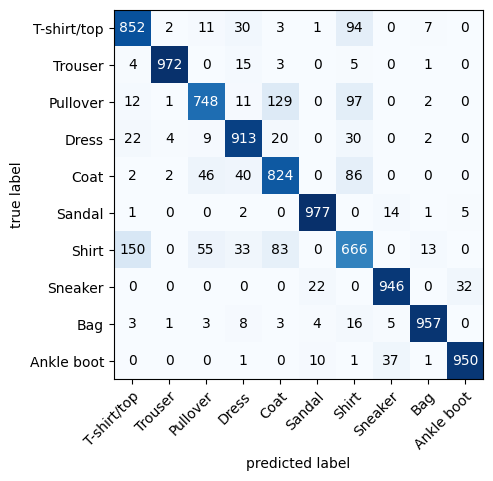

In [108]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names), task="multiclass")
confmat_tensor = confmat(preds = y_pred_tensor,
                         target=test_data.targets)

# Plot using mlxtend
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # Matplotlib works with numpy
    class_names=class_names
)

In [ ]:
confmat_tensor